In [4]:
import numpy as np
import json
import os
import sys
import matplotlib.pyplot as plt
import scienceplots  # optional, requires latex
plt.style.use(['science', 'grid'])

# Import plotting utility functions
sys.path.append('../')
from plot_util import (init_metrics, update_metrics, init_variables, update_variables,
                       plot_field, plot_field_residual, plot_field_columns, make_formatter, subsample_steps,
                        animate_frame, moving_average, moving_min)

In [16]:
# Select run to plot

results_folder = r"results"

measurments_type = ["displacement","strain"][0]
dic_measurments = 0
iteration = int(1e8)
time = 3
n_measurments = [50, 50]
noise = 0.0
dic_prefix = 'dic_' if dic_measurments else '' 
run_number = 1

run = f"{dic_prefix}{measurments_type}_{n_measurments[0]}x{n_measurments[1]}_{noise}noise_{time if time else iteration}{'min' if time else 'iter'}{f'-{run_number}' if run_number else ''}"
run_folder = os.path.join(results_folder, run)+"/"

In [17]:
# Load Configuration and Data

with open(os.path.join(run_folder, "config.json")) as f:
    run_config = json.load(f)

def read_data_file(filename):
    with open(filename, "r") as f:
        steps = []
        values = []
        for line in f.readlines():
            step, value = line.strip().split(' ', 1)
            steps.append(eval(step))
            values.append(eval(value))
    return steps, values

# Load loss and variable history data
loss_history = np.loadtxt(os.path.join(run_folder, "loss_history.dat"))
# loss_history_mean = moving_average(loss_history, 20)
# loss_history_min = moving_min(loss_history, 20)
variables_history = read_data_file(os.path.join(run_folder, "variables_history.dat"))

# Compute different metrics
residuals = loss_history[:, -1]
PDE_loss = np.mean(loss_history[:, 1:3], axis=1)
Mat_loss = np.mean(loss_history[:, 3:5], axis=1)
DIC_loss = np.mean(loss_history[:, 5:7], axis=1)
steps_loaded = loss_history[:, 0]

# Extract material parameters from config
# E_init = run_config["problem"]["E_init"] / 1e3  # Convert to GPa: 1e3 N/mm^2 = 1 GPa
# nu_init = run_config["problem"]["nu_init"]
# E_actual = run_config["problem"]["E_actual"] / 1e3  # Convert to GPa: 1e3 N/mm^2 = 1 GPa
# nu_actual = run_config["problem"]["nu_actual"]

# E_history = np.array(variables_history[1])[:len(steps_loaded), 0] / 1e3  # in GPa (1e3 N/mm^2 = 1 GPa)
# nu_history = np.array(variables_history[1])[:len(steps_loaded), 1]

# E_name = r"$E$"
# nu_name = r"$\nu$"

metrics = [residuals, PDE_loss, Mat_loss, DIC_loss]
metrics_names = ["Rel. l2 error", "PDE Loss", "Material Loss", "DIC Loss"]

# Configure x-axis based on iterations or elapsed time
step_type = "time"  # or "iteration"
time_unit = "min"   # or "s"
t_elapsed = run_config["execution"]["elapsed"]
if step_type == "time":
    steps = np.array(steps_loaded) * t_elapsed / steps_loaded[-1]
    if time_unit == "min":
        steps = steps / 60
else:
    steps = steps_loaded

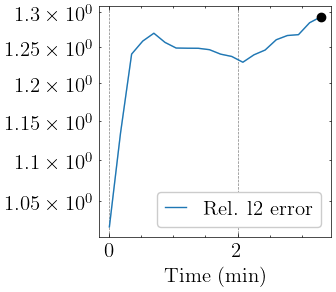

In [18]:
# Plot Metrics and Parameter Evolution

iteration = len(steps) - 1
# --- Plot Metrics ---
fig, ax_metric = plt.subplots(1, 1, figsize=(3, 3), dpi=100)
lines, scatters = init_metrics(ax_metric, steps, metrics, metrics_names, step_type=step_type, time_unit=time_unit, metrics_idx=[0])
update_metrics(iteration, lines, scatters, steps, metrics, metrics_idx=[0])
plt.show()

# --- Plot Parameter Evolution ---
# fig, axs_vars = plt.subplots(2, 1, figsize=(3, 6), dpi=100)
# line_E, line_nu, scatter_E, scatter_nu, axs_vars = init_variables(
#     axs_vars, steps, E_actual, nu_actual, E_history, nu_history, E_name, nu_name)
# update_variables(iteration, line_E, line_nu, scatter_E, scatter_nu,
#                  axs_vars, steps, E_history, nu_history, E_actual, nu_actual, E_name, nu_name)
# plt.show()

# --- Print Final Parameter Values ---
# E_final = np.mean(E_history[-10:])
# nu_final = np.mean(nu_history[-10:])
# print(f"{'Parameter':<15}{'Initial':<15}{'Final':<15}{'Reference':<15}{'Rel. Error (%)':<15}")
# print(f"{'E (GPa)':<15}{E_init:<15.2f}{E_final:<15.2f}{E_actual:<15.2f}{(abs(E_final - E_actual) / E_actual * 100):<15.3f}")
# print(f"{'nu':<15}{nu_init:<15.4f}{nu_final:<15.4f}{nu_actual:<15.4f}{(abs(nu_final - nu_actual) / nu_actual * 100):<15.3f}")

# # --- Combined Plot ---
# fig, axs_combined = plt.subplots(3, 1, figsize=(3, 9), dpi=150)
# lines, scatters = init_metrics(axs_combined[-1], steps, metrics, metrics_names, step_type=step_type, time_unit=time_unit, metrics_idx=[0])
# update_metrics(iteration, lines, scatters, steps, metrics, metrics_idx=[0])
# line_E, line_nu, scatter_E, scatter_nu, axs_vars = init_variables(
#     axs_combined[:2], steps, E_actual, nu_actual, E_history, nu_history, E_name, nu_name)
# update_variables(iteration, line_E, line_nu, scatter_E, scatter_nu,
#                  axs_vars, steps, E_history, nu_history, E_actual, nu_actual, E_name, nu_name)
plt.show()

In [19]:
# Load Field Data
field_names = run_config["network"]["logged_fields"]
fields_loaded = [0, 1, 2, 3, 4, 5, 6, 7] # 0: ux, 1: uy, 2: exx, 3: eyy, 4: exy to be loaded

n_plot_points = [150, 40]

fields = [None] * 8
for fid in fields_loaded:
    field_name = field_names[fid]
    _, V_pinn = read_data_file(os.path.join(run_folder, f"{field_name}_history.dat"))
    fields[fid] = np.array(V_pinn).reshape(-1, n_plot_points[1], n_plot_points[0], order='F').reshape(-1, n_plot_points[0]*n_plot_points[1])

In [20]:
# Field Plotting
import matplotlib.colors as mcolors
from scipy.interpolate import RegularGridInterpolator

# --- Font size for printing ---
plotting_factor = 5
font_factor = 5
title_font_size = 4
axes_font_size = 3
plt.rcParams.update({
    "font.size": title_font_size*font_factor,         # Default font size for all text
    "figure.titlesize": title_font_size*font_factor, 
    "axes.labelsize": axes_font_size*font_factor,
    "xtick.labelsize": axes_font_size*font_factor,
    "ytick.labelsize": axes_font_size*font_factor,
    "legend.fontsize": axes_font_size*font_factor,
})

plot_metrics = 0 # 1 to plot metrics, 0 to not plot metrics
fields_plotted = [0,1,2,3,4,5,6,7][:] #{0: "Ux", 1: "Uy", 2: "Sxx", 3: "Syy", 4: "Sxy"}
n_fields = len(fields_plotted)

# --- Custom colormap ---
cmap = plt.get_cmap('viridis')
num_colors = 20
color_values = [cmap(i) for i in np.linspace(0, 1, num_colors)]
cmap = mcolors.ListedColormap(color_values)

# --- Load FEM reference solution and create interpolators ---
dir_path = r"../data_fem"
fem_dataset = run_config["data"]["FEM_dataset"] 
n_rows, n_cols = map(int, fem_dataset.replace('.dat', '').split('_')[-1].split('x'))

data = np.loadtxt(os.path.join(dir_path, fem_dataset))
x_val      = data[:, 0]
y_val      = data[:, 1]
u_val = data[:, 2:4]
strain_val = data[:, 4:7]
stress_val = data[:, 7:10]
solution_val = np.hstack((u_val, strain_val, stress_val))
# Interpolate solution
x_grid = np.unique(x_val)
y_grid = np.unique(y_val)
interpolators = []
for i in range(solution_val.shape[1]):
    interp = RegularGridInterpolator((x_grid, y_grid), solution_val[:, i].reshape(n_rows, n_cols).T)
    interpolators.append(interp)
func = lambda x: np.array([interp((x[:, 0], x[:, 1])) for interp in interpolators]).T

# --- Prepare a square grid for field plotting ---
L = run_config["problem"]["L"]
w = run_config["problem"]["w"]
iteration = int(len(steps)*0.1) 
n_plot_points = [150, 40]

x_plot = np.linspace(0, L, n_plot_points[0]) 
y_plot = np.linspace(0, w, n_plot_points[1])
X, Y = np.meshgrid(x_plot, y_plot)
Xmesh, Ymesh = np.meshgrid(x_plot, y_plot)
# normdiff = set_normdiff(iteration, fields, fields_id, func, Xmesh, Ymesh)

# --- Plotting ---
subplot_width = plotting_factor
fig, ax = plt.subplots(3,plot_metrics+n_fields,figsize = (plot_metrics*subplot_width+n_fields*subplot_width*2,subplot_width*3),dpi = 40*plot_metrics+40*n_fields)
printed_font_size = 6
title_font_size = plt.rcParams['font.size']
axes_font_size = ax[0][0].get_xticklabels()[0].get_fontsize()
print(f"Fig width: {fig.get_figwidth()}, set it to {fig.get_figwidth()*printed_font_size/title_font_size:.2f} < 6.34 (A4 with margins) in latex to have a printed font size of {printed_font_size} for titles and {axes_font_size*printed_font_size/title_font_size:.2f} for the axis")

# Plot parameter evolution on ax_var1 and ax_var2 using functions from plot_util
if plot_metrics:
    # axs_var = [ax[0][0], ax[1][0]]
    # line_E, line_nu, scatter_E, scatter_nu, ax_variables = init_variables(
    #     axs_var,
    #     steps, E_actual, nu_actual, E_history, nu_history,
    #     E_name, nu_name
    # )
    # update_variables(iteration, line_E, line_nu, scatter_E, scatter_nu,
    #                 axs_var,
    #                 steps, E_history, nu_history,
    #                 E_actual, nu_actual, E_name, nu_name)

    # Plot metrics on ax_metric
    lines, scatters = init_metrics(ax[0][0], steps, metrics, metrics_names, 
                                step_type=step_type, time_unit=time_unit, metrics_idx=[0])
    update_metrics(iteration, lines, scatters, steps, metrics, metrics_idx=[0])

ims_field = []
ims_ref = []
ims_res = []
ax_fields = ax[:, plot_metrics:]
ims_ref, ims_field, ims_res = plot_field_columns(fig, ax_fields, fields, fields_plotted, iteration,
                                                  Xmesh, Ymesh, func, field_names, cmap, make_formatter)

plt.tight_layout
plt.show()

Fig width: 80.0, set it to 24.00 < 6.34 (A4 with margins) in latex to have a printed font size of 6 for titles and 4.50 for the axis


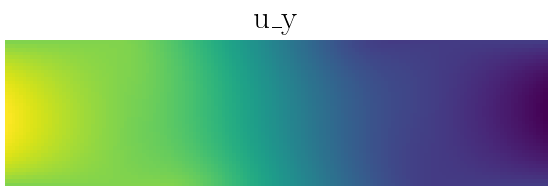

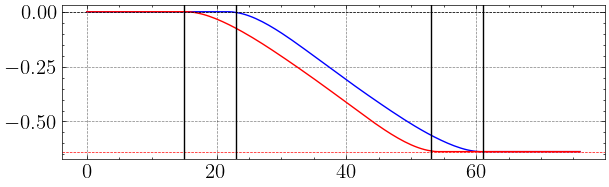

In [21]:
from plot_util import pcolor_plot

fields_to_plot = fields[1][-1]
# fields_to_plot = func(np.array([Xmesh.flatten(), Ymesh.flatten()]).T)[:,5]

u_right = -0.637382 # right clamp displacement from FEM simulation
J1S = run_config["problem"]["J1S"]
J1L = run_config["problem"]["J1L"]
J2S = run_config["problem"]["J2S"]
J2L = run_config["problem"]["J2L"]

fig, ax = plt.subplots(1, 1, figsize=(7, 2))
im = pcolor_plot(ax, X, Y, fields_to_plot.reshape(X.shape), "u_y")

# Plot the hard boundary condition
fig, ax = plt.subplots(1, 1, figsize=(7, 2))
plt.plot(x_plot, fields_to_plot.reshape(X.shape)[0,:], label='Top Boundary Condition', color='blue')
plt.plot(x_plot, fields_to_plot.reshape(X.shape)[-1,:], label='Bottom Boundary Condition', color='red')
ax.axhline(0, color='black', linestyle='--', linewidth=0.5)
ax.axhline(u_right, color='red', linestyle='--', linewidth=0.5)
ax.axvline(J1S, color='k', linestyle='-', linewidth=1)
ax.axvline(J1L, color='k', linestyle='-', linewidth=1)
ax.axvline(L - J2S, color='k', linestyle='-', linewidth=1)
ax.axvline(L - J2L, color='k', linestyle='-', linewidth=1)

/tmp/ipykernel_3789/3841795127.py:100: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_3789/3841795127.py:85: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  axs[ind[0]][ind[1]].set_xlim([min(x_bc), max(x_bc)])


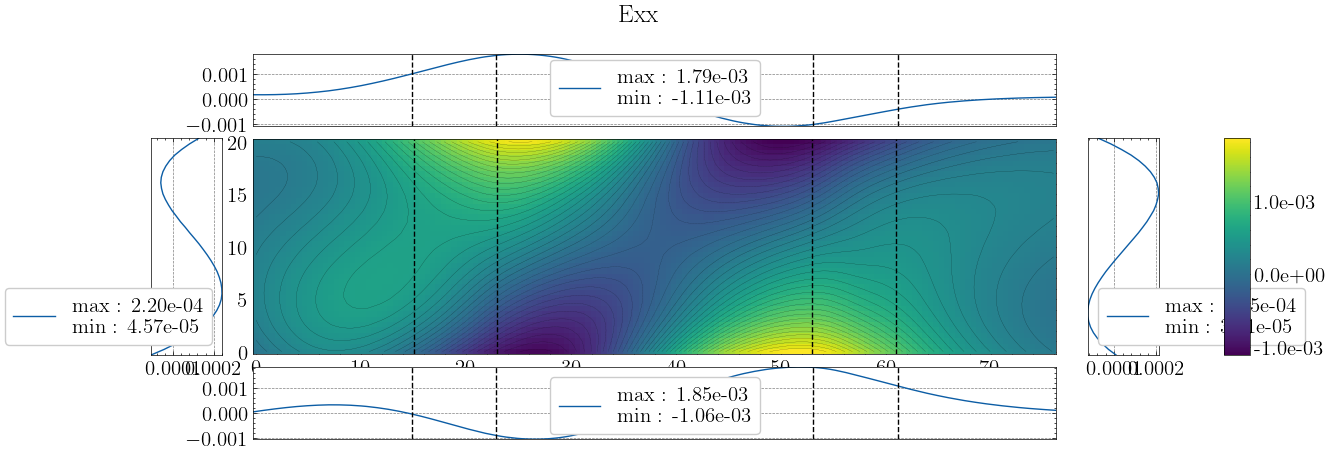

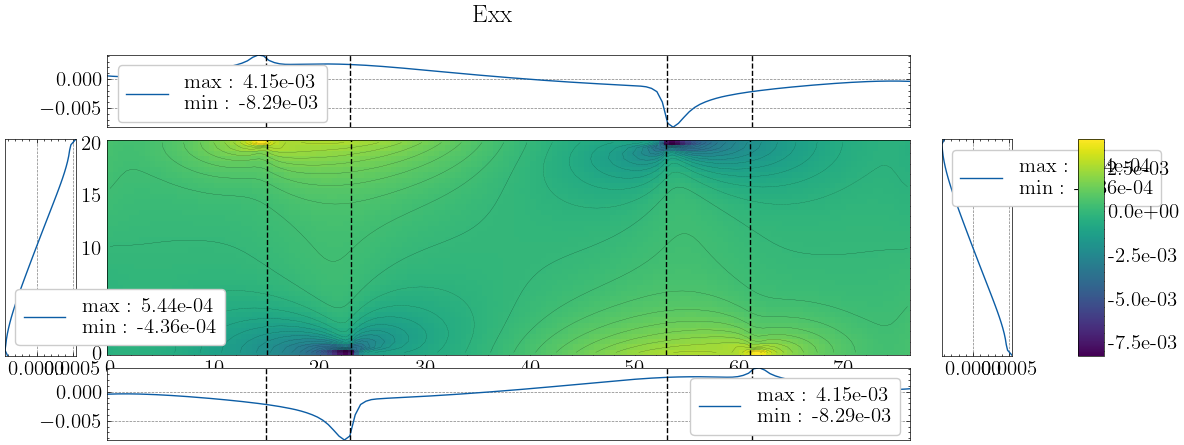

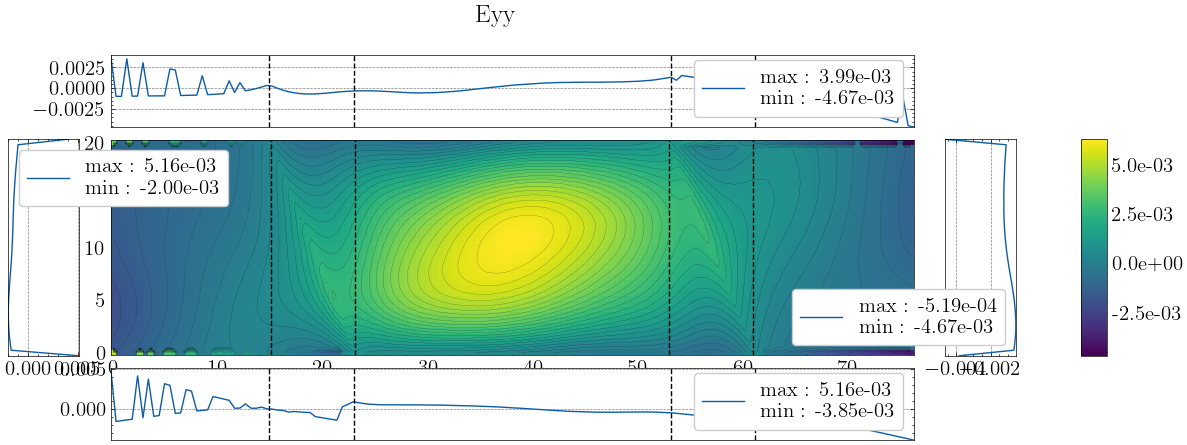

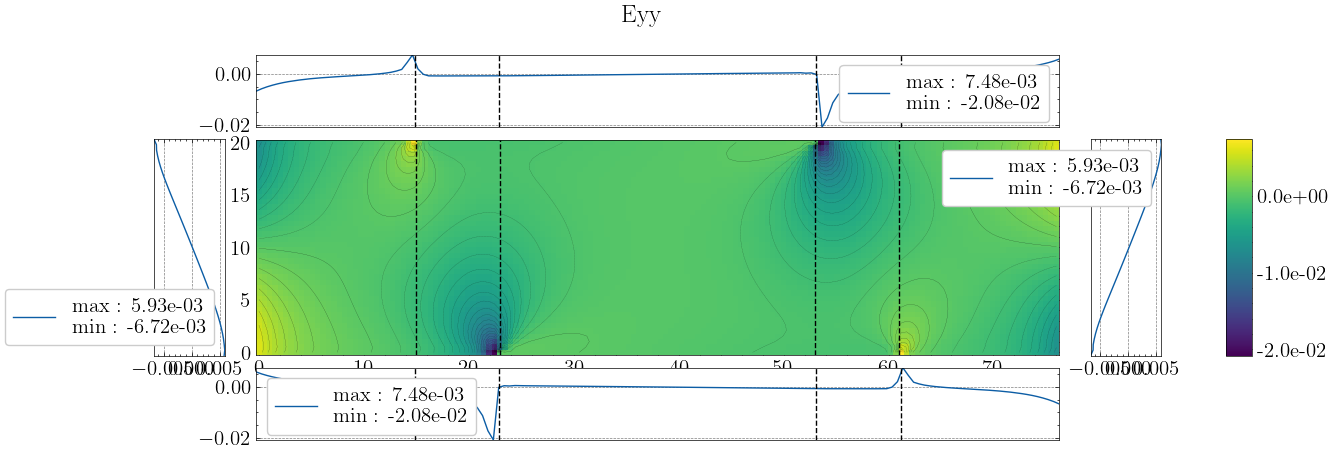

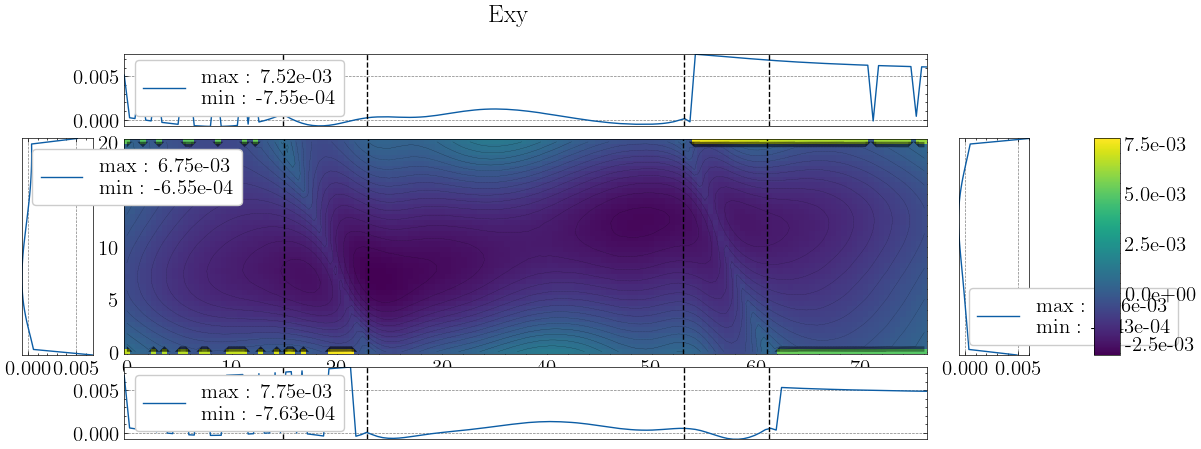

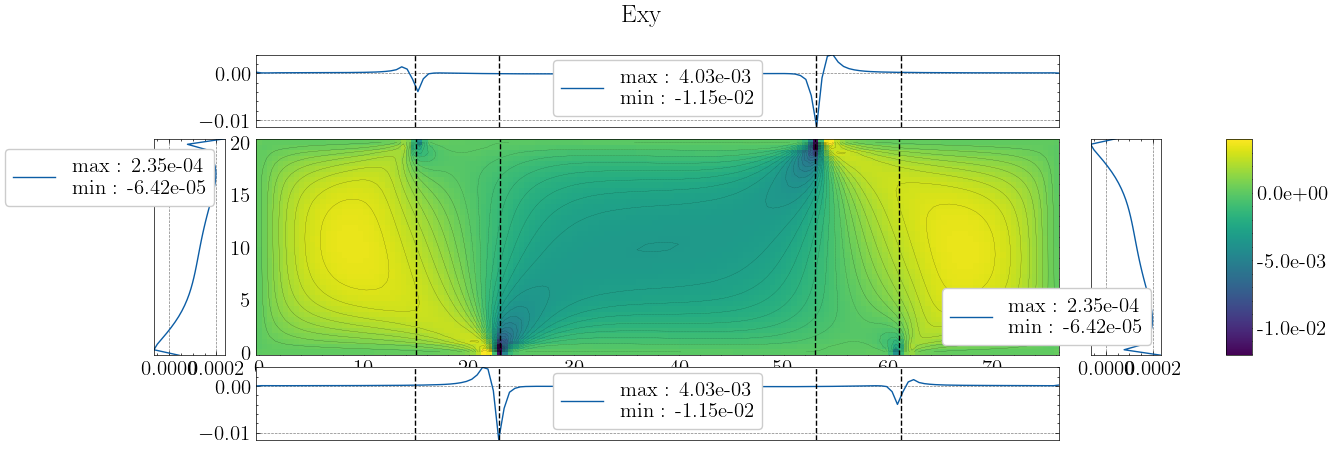

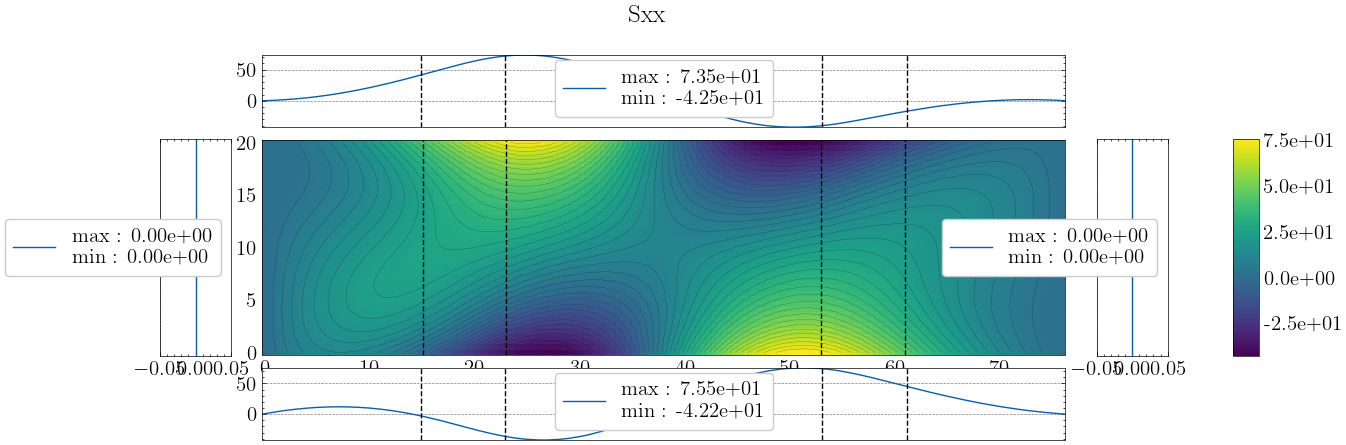

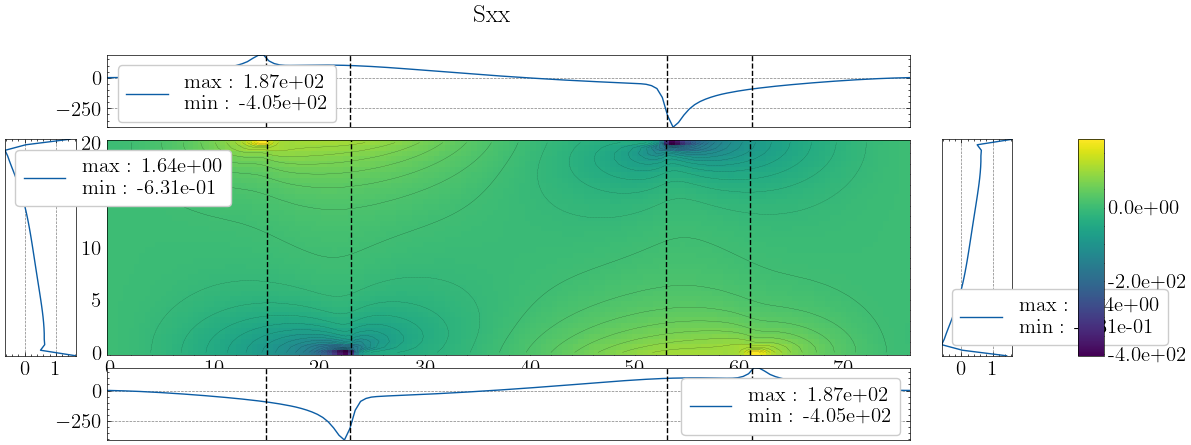

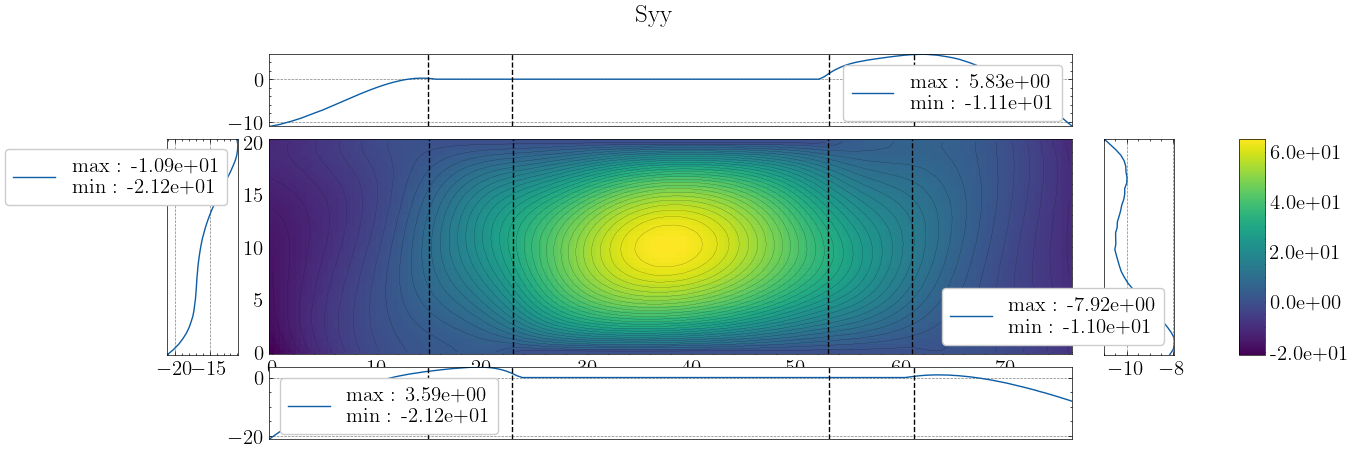

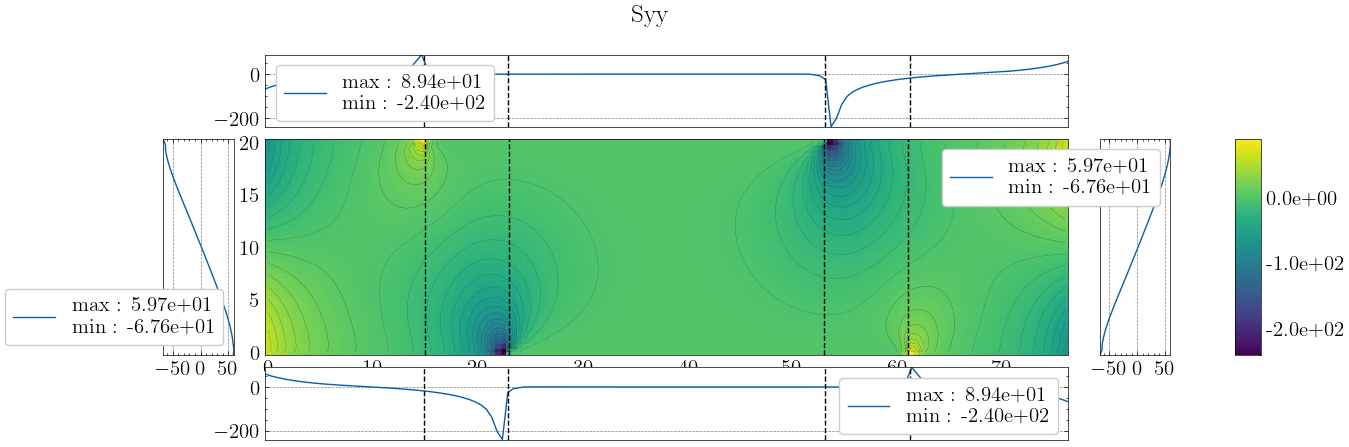

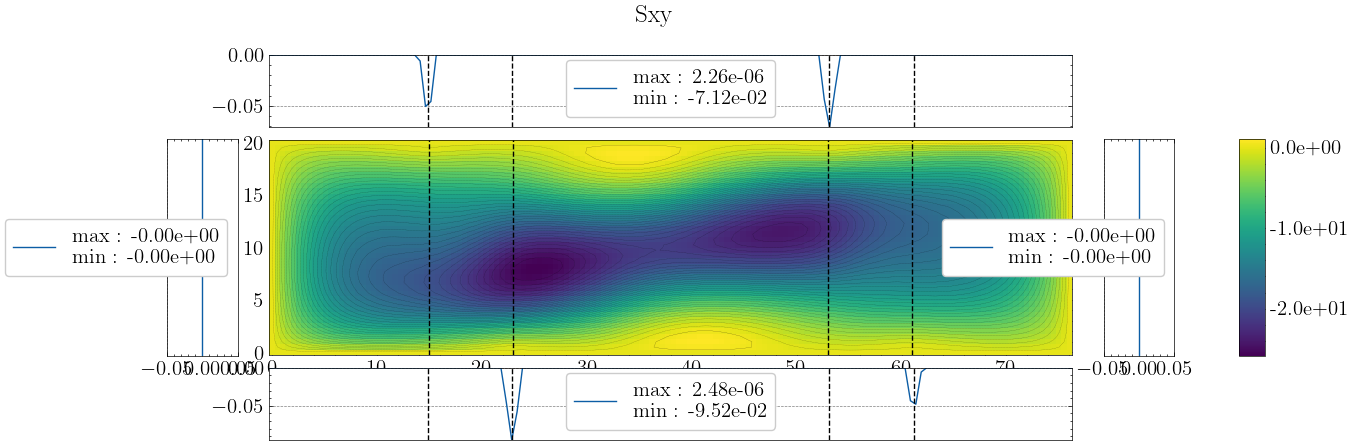

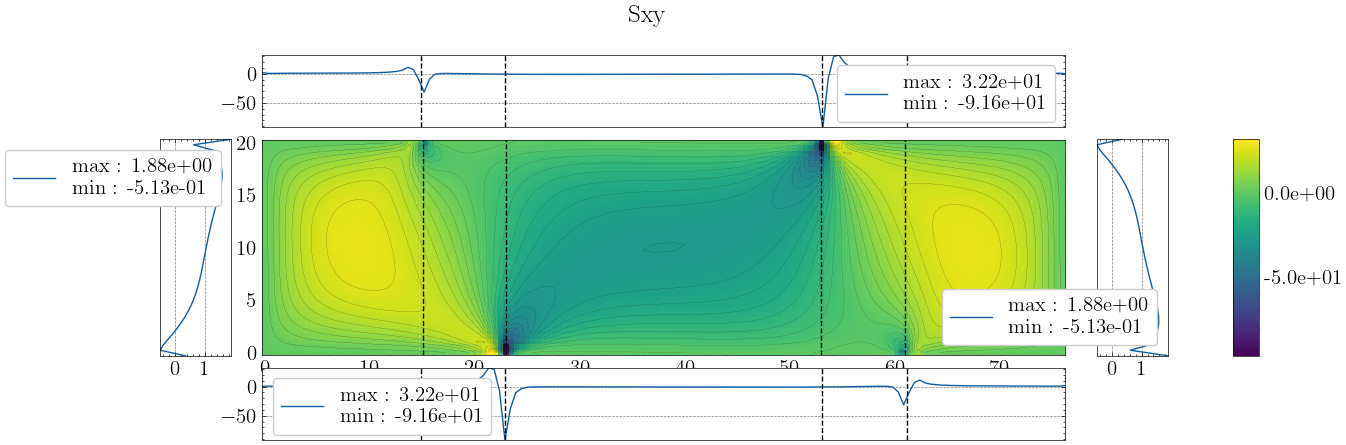

In [22]:
import matplotlib.ticker as ticker


def pcolor_plot(AX, X, Y, C, title, colormap="viridis", set_axis='on', colorbar=True, contour=True, n_levels=40, **kwargs):
    """
    Plots a pcolor plot with optional contour lines.
    
    Parameters:
        AX (matplotlib.axes): The axis to plot on.
        X, Y (2D array): Grid coordinates.
        C (2D array): Scalar field to plot.
        title (str): Plot title.
        colormap (str or Colormap): Colormap to use.
        set_axis (str): 'on' or 'off' to control axis visibility.
        colorbar (bool): Whether to display a colorbar.
        contour (bool): If True, adds contour lines.
        n_levels (int): Number of contour levels.
        kwargs: Optional `cmin` and `cmax` for color limits.
    """
    formatter = ticker.ScalarFormatter(useMathText=True)
    formatter.set_scientific(True)
    formatter.set_powerlimits((-3, 3))

    cmin = kwargs.get("cmin", None)
    cmax = kwargs.get("cmax", None)

    im = AX.pcolormesh(X, Y, C, cmap=colormap, shading='auto', vmin=cmin, vmax=cmax)

    if contour:
        levels = np.linspace(np.min(C) if cmin is None else cmin,
                             np.max(C) if cmax is None else cmax,
                             n_levels)
        AX.contour(X, Y, C, levels=levels, colors='k', linewidths=0.1)

    AX.set_aspect("equal", "box")
    AX.axis(set_axis)
    AX.set_title(title, fontsize=14)

    if colorbar:
        fig = AX.get_figure()
        fig.colorbar(im, ax=AX, format=formatter)

    return im

def plot_boundary(F, F_bc, X, Y, title, axs):
    x_top = X[-1,:]
    x_bottom = X[0,:]
    y_left = Y[:,0]
    y_right = Y[:,-1]

    F_top = F_bc[-1,:]
    F_bottom = F_bc[0,:]
    F_left = F_bc[:,0]
    F_right = F_bc[:,-1]

    x_bcs = [x_top, x_bottom, F_left, F_right] 
    y_bcs = [F_top, F_bottom, y_left, y_right]

    index_bcs = [[0,1],[2,1],[1,0],[1,2]]

    axs[0][0].axis("off")
    axs[0][2].axis("off")
    axs[2][0].axis("off")
    axs[2][2].axis("off")

    for i, (x_bc, y_bc, ind) in enumerate(zip(x_bcs, y_bcs, index_bcs)):
        # axs[ind[0]][ind[1]].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{x:.1e}"))
        ax = axs[ind[0]][ind[1]]
        if i<2:
            axs[ind[0]][ind[1]].plot(x_bc, y_bc, label=f"max : {np.max(y_bc):.2e}\nmin : {np.min(y_bc):.2e}")
            axs[ind[0]][ind[1]].xaxis.set_visible(False)
            axs[ind[0]][ind[1]].set_xlim([0, L])
            axs[ind[0]][ind[1]].set_ylim([min(y_bc), max(y_bc)])
            #log scale
            # axs[ind[0]][ind[1]].set_yscale('log')
            ax.axvline(J1S, color='k', linestyle='--', linewidth=1)
            ax.axvline(J1L, color='k', linestyle='--', linewidth=1)
            ax.axvline(L - J2S, color='k', linestyle='--', linewidth=1)
            ax.axvline(L - J2L, color='k', linestyle='--', linewidth=1)

        else:
            axs[ind[0]][ind[1]].plot(x_bc, y_bc, label=f"max : {np.max(x_bc):.2e}\nmin : {np.min(x_bc):.2e}")
            axs[ind[0]][ind[1]].yaxis.set_visible(False)
            axs[ind[0]][ind[1]].set_ylim([0, w])
            axs[ind[0]][ind[1]].set_xlim([min(x_bc), max(x_bc)])
            #log scale
            # axs[ind[0]][ind[1]].set_xscale('log')
        axs[ind[0]][ind[1]].legend()
            
    im = pcolor_plot(axs[1][1], X, Y, F, None, colorbar=False)
    ax = axs[1][1]
    ax.axvline(J1S, color='k', linestyle='--', linewidth=1)
    ax.axvline(J1L, color='k', linestyle='--', linewidth=1)
    ax.axvline(L - J2S, color='k', linestyle='--', linewidth=1)
    ax.axvline(L - J2L, color='k', linestyle='--', linewidth=1)
    axs[1][1].set_zorder(-1)
    pos = axs[1][2].get_position()
    cax = fig.add_axes([pos.width + pos.x0 +0.05, pos.y0, 0.02, pos.height])
    fig.colorbar(im, cax=cax, format=ticker.FuncFormatter(lambda x, _: f"{x:.1e}"))
    plt.tight_layout()
    plt.suptitle(title, fontsize=18)

fields_exact = [func(np.array([Xmesh.flatten(), Ymesh.flatten()]).T)[:,i].reshape(X.shape) for i in range(8)][2:]
# fields_last = fields_exact[-3:]
fields_last = [fields[i][-1].reshape(X.shape) for i in fields_plotted][2:]
fields_last_bc = fields_last
# fields_bc = fields_bc[-1:]
titles = ["Ux", "Uy", "Exx", "Eyy", "Exy", "Sxx", "Syy", "Sxy"][2:]

for i,title in enumerate(titles):
    field_last = fields_last[i].reshape(X.shape)
    field_last_bc = fields_last_bc[i]
    fig, axs = plt.subplots(3, 3, figsize=(13, 5), height_ratios=[0.2, 0.6, 0.2], width_ratios=[0.075, 0.85, 0.075], gridspec_kw={"hspace": 0.1, "wspace": 0.1})
    plot_boundary(field_last, field_last_bc, X, Y, title, axs)

    field_exact = fields_exact[i].reshape(X.shape)
    field_exact_bc = fields_exact[i]
    fig, axs = plt.subplots(3, 3, figsize=(13, 5), height_ratios=[0.2, 0.6, 0.2], width_ratios=[0.075, 0.85, 0.075], gridspec_kw={"hspace": 0.1, "wspace": 0.1})
    plot_boundary(field_exact, field_exact_bc, X, Y, title, axs)

In [ ]:
# Save figure
fig_name = f"{run}_"+ "_".join([field_names[fid] for fid in fields_plotted]) 
fig.savefig(f'./{fig_name}.png', dpi=500, bbox_inches='tight')

Theoretical value: 6500.00
SPINN mean: 154810.76
FEM mean: 6499.98
SPINN error: 21996081399.49
FEM error: 1.64


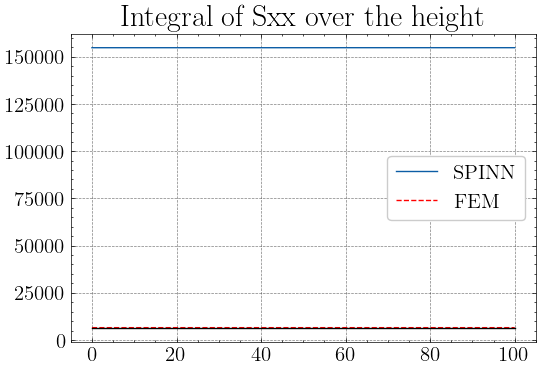

In [69]:
m, b  = 0.3, 50
L_max = 100
coord_normalization = 0


n_integral = 100
x_integral = np.linspace(0, L_max, n_integral)
y_integral = np.linspace(0, L_max, n_integral)
X_integral, Y_integral = np.meshgrid(x_integral, y_integral, indexing='ij')
# X_integral = X_integral.reshape(-1, 1)
# Y_integral = Y_integral.reshape(-1, 1)
# Xmesh = X_integral
# Ymesh = Y_integral

Sxx = fields[5]
Sxx = np.array(Sxx[-1]).reshape(X_integral.shape)
Sxx_exact = func(np.hstack((X_integral.reshape(-1, 1), Y_integral.reshape(-1, 1))))[:,5].reshape(X_integral.shape)
Integral_x = np.trapezoid(Sxx, Y_integral, axis=1)
Integral_x_exact = np.trapezoid(Sxx_exact, Y_integral, axis=1) 

fig = plt.figure(figsize=(6,4))
plt.plot(Y_integral[0,:], Integral_x,label="SPINN")
plt.plot(Y_integral[0,:], Integral_x_exact,linestyle="--", color="r", label="FEM")
theo_val = (b+m*L_max/2)*L_max

plt.plot([0, L_max], [theo_val, theo_val], color="k")
plt.legend()
plt.title("Integral of Sxx over the height")

spinn_error = np.mean(np.square(theo_val - Integral_x))
fem_error = np.mean(np.square(theo_val - Integral_x_exact))
print(f"Theoretical value: {theo_val:.2f}")
print(f"SPINN mean: {np.mean(Integral_x):.2f}")
print(f"FEM mean: {np.mean(Integral_x_exact):.2f}")
print(f"SPINN error: {spinn_error:.2f}")
print(f"FEM error: {fem_error:.2f}") 

In [269]:
# Animation
import matplotlib.animation as animation
from IPython.display import HTML

# Add time to the title
fig.suptitle(f"{step_type}: {steps[iteration]:.0f}{f'{time_unit}' if step_type == 'time' else ''}", fontsize=20, y=1)

# Prepare a list of frame indices (subsample if desired)
all_steps = list(range(len(steps)))
sub_factors = [1,2] + [3]*3  # Adjust subsampling factors as needed
frame_steps = list(subsample_steps(all_steps, sub_factors))

# Reuse the figure from Cell 4 (or create a new one if preferred)
anim = animation.FuncAnimation(
    fig,
    animate_frame,
    frames=frame_steps,
    fargs=(ims_field, ims_res, line_E, line_nu, scatter_E, scatter_nu,
           axs_var, lines, scatters, steps, time_unit, step_type,
           E_history, nu_history, E_actual, nu_actual,
           E_name, nu_name, metrics, fields, func, Xmesh, Ymesh, field_names, fields_plotted),
    interval=100,
    repeat=False
)

fps = 10
print("Video duration: ", len(frame_steps)/fps, "s")
# HTML(anim.to_jshtml())

NameError: name 'line_E' is not defined

In [14]:
# Save video
fig_name = f"{run}_"+ "_".join([field_names[fid] for fid in fields_plotted]) 
extension = ".mp4"  # or ".gif"
video_name = f"{fig_name}_{step_type}{extension}"
anim.save(video_name, writer='ffmpeg', fps=fps)

print(f"Video saved at {video_name}")

Video saved at strain_x16_1e-06noise_2min_Ux_Uy_Sxx_Syy_Sxy_time.mp4


<Figure size 350x262.5 with 0 Axes>